In [5]:
from cmdstanpy import CmdStanModel

from seaborn import jointplot
import arviz as az
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import pandas as pd

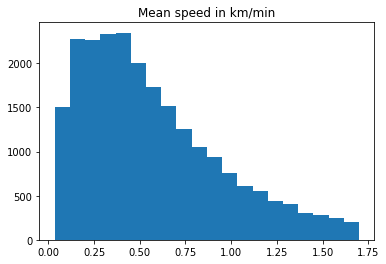

1    7947
4    6984
3    5719
2    2368
Name: Road_traffic_density, dtype: int64

In [6]:
df = pd.read_csv('delivery_time_data.csv', delimiter=';', decimal=',')

df = df[df["Road distances [km]"] < 17.5]

# display(df.describe())

train_df = pd.DataFrame(df.iloc[:, :])
train_df["Mean speed"] = train_df["Road distances [km]"] / (train_df["Time_taken(min)"] - train_df["Meal_preparation_time"]) 
train_df = train_df[train_df["Mean speed"] < 1.7]
plt.hist(train_df["Mean speed"], bins=20)
plt.title("Mean speed in km/min")
plt.show()
# display(train_df["Road_traffic_density"].value_counts())
# plt.title("Count of density type")
# plt.show()

# train_df["Mean speed"].describe()
# train_df["Time_taken(min)"].describe()
# train_df.head()

road_density_map = {'Jam ':1, 'High ':2, 'Medium ':3, 'Low ':4}

train_df["Road_traffic_density"] = train_df["Road_traffic_density"].apply(lambda x: road_density_map[x])
display(train_df["Road_traffic_density"].value_counts())


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


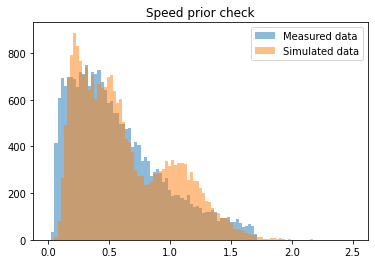

255.719

0.0592238

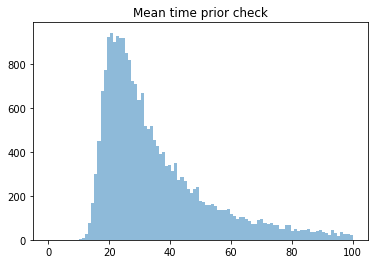

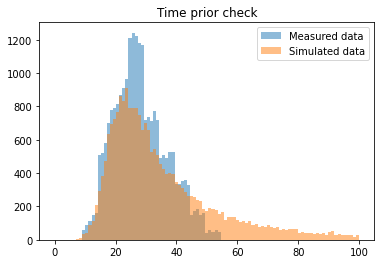

In [7]:
model_ppc=CmdStanModel(stan_file='basic_ppc.stan')

sim=model_ppc.sample(data={"N": len(train_df), "distance": train_df["Road distances [km]"].values,"meal_preparation_time": train_df["Meal_preparation_time"].values,"traffic_level" :train_df["Road_traffic_density"].values}, 
                     iter_sampling=1,
                     iter_warmup=0, 
                     chains=1, 
                     fixed_param=True,
                     seed=29042020)
ppc_df = sim.draws_pd()

bins = np.linspace(0,100,100)

speed_bins = np.linspace(0,2.5,100)
speed = ppc_df.filter(regex="beta.*")
plt.hist(train_df["Mean speed"],bins=speed_bins ,alpha=0.5, label="Measured data")
plt.hist(speed.values.flatten(),bins=speed_bins, alpha=0.5, label="Simulated data")
plt.title("Speed prior check")
plt.legend()
plt.show()

mean_for_gamma = ppc_df.filter(regex="mu.*")
delivery = ppc_df.filter(regex="delivery_time.*")
display(mean_for_gamma.iloc[0,:].max())
# delivery.iloc[:,:].apply(pd.DataFrame.describe, axis=1)
# delivery['value'].describe()
display(speed.loc[0,:].min())
plt.hist(mean_for_gamma.values.flatten(),bins=bins, alpha=0.5, label="Mu")
plt.title("Mean time prior check")
plt.show()

plt.hist(train_df["Time_taken(min)"],bins=bins ,alpha=0.5, label="Measured data")
plt.hist(delivery.values.flatten(),bins=bins, alpha=0.5, label="Simulated data")
plt.title("Time prior check")
plt.legend()
plt.show()

## Model fit

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


,lp__,accept_stat__,beta[1],beta[2],beta[3],beta[4],beta[5],beta[6],beta[7],beta[8],...,delivery_time[23009],delivery_time[23010],delivery_time[23011],delivery_time[23012],delivery_time[23013],delivery_time[23014],delivery_time[23015],delivery_time[23016],delivery_time[23017],delivery_time[23018]
0,0.0,0.0,15.96,25.6272,55.523,57.5001,16.5115,24.1401,36.9595,14.779,...,17.6833,22.0227,25.5713,27.5821,18.9443,36.4991,28.1785,16.4417,15.1981,26.0019


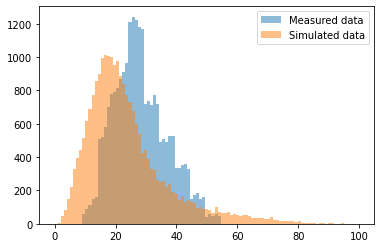

In [8]:
basic_fit=CmdStanModel(stan_file='basic_fit.stan')

basic_sample=basic_fit.sample(data={"N": len(train_df), "distance": train_df["Road distances [km]"].values,"meal_preparation_time": train_df["Meal_preparation_time"].values, "delivery_times": train_df["Time_taken(min)"].values, "traffic_level" :train_df["Road_traffic_density"].values},
                              iter_sampling=1,
                              chains=1,
                              iter_warmup=0,
                              fixed_param=True
                         )


df_fit = basic_sample.draws_pd()
display(df_fit.head())
delivery_fit = df_fit.filter(regex="delivery_time.*")
# df_fit.iloc[:, 8:]
plt.hist(train_df["Time_taken(min)"], bins=bins, alpha=0.5, label="Measured data")
plt.hist(delivery_fit.values.flatten(),bins=bins, alpha=0.5, label="Simulated data")
plt.legend()